In [1]:
import matplotlib
import matplotlib.pyplot as plt
import mrlattice.lattice as lat
import numpy as np

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.1"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Summary

We demonstrate how to add new functionality to the LatticeArray class. First we add propagation of pulse segments. Then we add the options to mirror the entire lattice in temporal and/or spatial direction.


# Lattice Modifiers

## Propagate Segment
The main goal we tackle in this section is to "activate" the three sliders that until now had no use:
- Width of Coarsest Region
- Width of Finest Region
- Numer of Segment Repetitions

As we planned ahead, the sliders are already linked up to appropriate properties of `LatticeArray`. So the only task left to complete is to implement the affect of those sliders (the "logic") into `LatticeArray`. We use our existing code in `_propagate_pulse()` that propagates the pulse segment in positive spatial and temporal direction (to the upper right).  
Hovewer, we did a few modifications to the previous code. Aside from the obvious changes to work with LatticeArray properties, we also included the `finest_width` property as the number of finest cells to fill the right buffer with. This required a change of `rbuffer` and the appropriate scaling of the right most region in the lattice array `out[t]`.  
Of course we also have to add our new propagation code to the `generate_arra()` function of LatticeArray.

The result below has all sliders working. (Two checkboxes are still useless, though.)

In [6]:
class NewLatticeArray(lat.LatticeArray):
    
    def generate_array(self):
        super().generate_array()

        # modify lattice segment
        self._propagate_pulse()


    def _propagate_pulse(self):
        """Propagate self.array from lower left to upper right.

        This modifies the `.array` property.
        """
        # get resolution of boundaries of lat in units # of finest mesh
        coa = 2 ** self.coarse_steps.value
        l_coarsest_t = coa
        l_coarsest_x = l_coarsest_t
        out_t = self.repeat.value * len(self.array)

        out = np.empty(out_t, dtype=object)

        # buffer on the right (in coarsest units)
        rbuffer = self.repeat.value - 1

        # calculate each time slice's regions
        for t in range(out_t):
            # number of buffer cells
            q, r = divmod(t, l_coarsest_t)
            out[t] = (
                ((l_coarsest_t, l_coarsest_x, self.buffer.value + q),)
                + self.array[r]
                + ((1, 1, (rbuffer - q) * coa + self.finest_width.value - 1),)
            )

        self._array = out

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

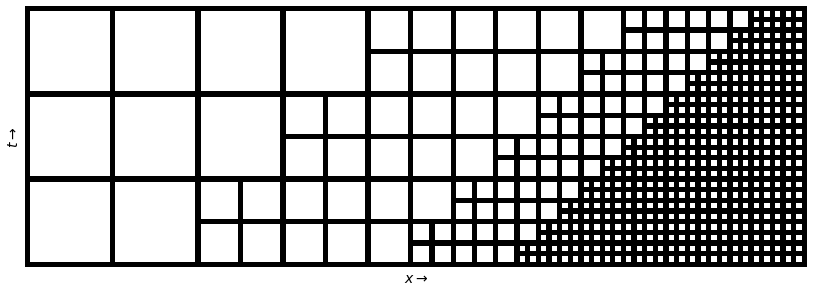

In [7]:
init_param_dict = {
    "scheme": "fixed_number",
    "coarse_steps": 3,
    "borders_width": 5,
    "buffer": 2,
    "finest_width": 5,
    "repeat": 3,
}
new_w = LatticeArrayPlotWidget(lattice=NewLatticeArray(**init_param_dict))
new_w.alpha_bg.value = True
display(new_w)

## Spatial and Temporal Mirror

As a next step we add the options to mirror the entire lattice in temporal or spacial direction. Again, we can just use the functions from previous notebooks. We add them as staticmethods, in aticipation that we might want to use them later on array segments directly, without needing properties (especially the full `.array`) of the LatticeArray instance.  
Again we add to `generate_array()`. This time we also add two optional parameters to control what mirroring action to perform.

In order to control the mirroring action from our plot widget, we need to append to it as well. We add two new checkboxes and register them with the VBOX output widget's children. In order to use the new options with NewNewLatticeArray, we have to completely overwrite the `_plot_button_on_click()` function. This is necessary, even if we only want to add two arguments to the call to `generate_lattice()`.

In [8]:
class NewNewLatticeArray(NewLatticeArray):
    
    def generate_array(self, flip_x=False, flip_t=False):
        super().generate_array()
        
        if flip_x:
            self._array = self._spatial_mirror(self.array, self.array)
        if flip_t:
            self._array = self._temporal_mirror(self.array, self.array)

    @staticmethod
    def _spatial_mirror(lat, out=None):
        """Mirror the given lat in spatial direction.

        Args:
            lat: Lattice array. Usually `.array` property.
            out: Lattice array to save output. Shape has to match lat.

        Returns:
            If `out` is not given, return a new lattice array. Else
            change `lat` in place and return `lat`.
        """
        if out is None:
            out = np.empty(len(lat), dtype=object)

        # for each time slice
        for t, ll in enumerate(lat):
            # reverse the regions
            out[t] = tuple(reversed(ll))

        return out

    @staticmethod
    def _temporal_mirror(lat, out=None):
        """Mirror the given lat in temporal direction.

        Args:
            lat: Lattice array. Usually `.array` property.
            out: Lattice array to save output. Shape has to match lat.

        Returns:
            If `out` is not given, return a new lattice array. Else
            return a view of `lat`.
        """
        if out is None:
            out = np.copy(lat)
        else:
            # this also works if out is lat
            np.copyto(out, lat)

        return np.flipud(out)

In [9]:
class NewLatticeArrayPlotWidget(LatticeArrayPlotWidget):
    
    def __init__(self, lattice=None, max_vals=None):
        super().__init__(lattice=lattice, max_vals=max_vals)
        
        self.flip_x = widgets.Checkbox(
            description="Flip Lattice in Spatial Direction",
            indent=False,
        )
        self.flip_t = widgets.Checkbox(
            description="Flip Lattice in Temporal Direction",
            indent=False,
        )
        
        # very confusing nesting of widgets... :(
        # but less code then a full copy-paste of the original
        self.children[0].children[0].children[4].children = (
            list(self.children[0].children[0].children[4].children) +
                                          [self.flip_x, self.flip_t])
    
    
    def _plot_button_on_click(self, *args):
        self._clear_output()
        with self.plot_out:
            self.lattice.generate_array(self.flip_x.value, self.flip_t.value)
            self.fig_out, self.ax_out = mrlattice.plotting.plot_mesh(
                mrlattice.plotting.generate_plot_lattice(self.lattice.array),
                alpha_bg=self.alpha_bg.value
            )
            self.fig_out

NewLatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Border…

Output()

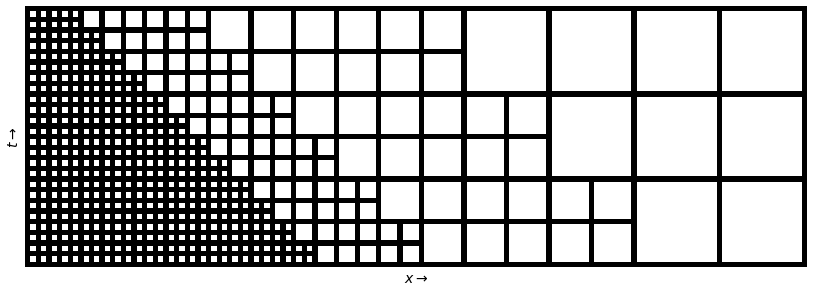

In [10]:
newnew_w = NewLatticeArrayPlotWidget(lattice=NewNewLatticeArray(**init_param_dict))
newnew_w.alpha_bg.value = True
newnew_w.flip_x.value = True
display(newnew_w)